In [1]:
# Cell 1: Imports and Setup
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.metrics import mean_absolute_error

In [2]:
# Forward kinematics function (for generating data and evaluation)
def forward_kinematics_3dof(theta1, theta2, theta3, l1, l2, l3):
    x = l1 * np.cos(theta1) * np.sin(theta2) + l2 * np.cos(theta1) * np.sin(theta2 + theta3)
    y = l1 * np.sin(theta1) * np.sin(theta2) + l2 * np.sin(theta1) * np.sin(theta2 + theta3)
    z = l1 * np.cos(theta2) + l2 * np.cos(theta2 + theta3) + l3
    return x, y, z

In [3]:
# Generate dataset for inverse kinematics
def generate_dataset(num_samples=1_000_000):
    l1, l2, l3 = 1.0, 1.5, 0.5  # link lengths
    theta1 = np.random.uniform(-np.pi/2, np.pi/2, num_samples)
    theta2 = np.random.uniform(-np.pi/2, np.pi/2, num_samples)
    theta3 = np.random.uniform(-np.pi/2, np.pi/2, num_samples)
    
    inputs = np.array([forward_kinematics_3dof(t1, t2, t3, l1, l2, l3) for t1, t2, t3 in zip(theta1, theta2, theta3)])
    outputs = np.column_stack((theta1, theta2, theta3))
    
    return inputs, outputs

In [4]:
def save_dataset(inputs, outputs, filename='robot_arm_dataset'):
    np.savez(filename, inputs=inputs, outputs=outputs)
    print(f"Dataset saved to {filename}.npz")

def load_dataset(filename='robot_arm_dataset.npz'):
    data = np.load(filename)
    return data['inputs'], data['outputs']

In [5]:
# Neural Network Model for Inverse Kinematics
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(3,)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(3)  # Output: 3 joint angles
    ])
    return model

In [6]:
# Cell 5: Custom Learning Rate Schedule
class CosineDecayWithWarmup(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, peak_learning_rate, warmup_steps, decay_steps):
        super(CosineDecayWithWarmup, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.peak_learning_rate = peak_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps
        self.cosine_decay = tf.keras.experimental.CosineDecay(
            peak_learning_rate, decay_steps - warmup_steps, alpha=initial_learning_rate / peak_learning_rate)

    @tf.function
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        
        warmup_lr = self.initial_learning_rate + (self.peak_learning_rate - self.initial_learning_rate) * (step / self.warmup_steps)
        cosine_lr = self.cosine_decay(step - self.warmup_steps)
        
        lr = tf.cond(step < self.warmup_steps,
                     lambda: warmup_lr,
                     lambda: cosine_lr)
        
        return tf.cast(lr, tf.float32)

    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "peak_learning_rate": self.peak_learning_rate,
            "warmup_steps": self.warmup_steps,
            "decay_steps": self.decay_steps,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [7]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(LearningRateLogger, self).__init__()
        self.lr_rates = []

    def on_batch_begin(self, batch, logs=None):
        lr = self.model.optimizer.lr
        if hasattr(lr, '__call__'):
            lr = lr(self.model.optimizer.iterations)
        self.lr_rates.append(lr.numpy())

def train_network(model, train_dataset, val_dataset, epochs=100):
    total_steps = epochs * len(train_dataset)
    warmup_steps = total_steps // 10
    
    lr_schedule = CosineDecayWithWarmup(
        initial_learning_rate=1e-4,
        peak_learning_rate=1e-3,
        warmup_steps=warmup_steps,
        decay_steps=total_steps
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_logger = LearningRateLogger()
    
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
            tf.keras.callbacks.CSVLogger('training_log.csv'),
            early_stopping,
            tf.keras.callbacks.TerminateOnNaN(),
            lr_logger
        ]
    )
    
    # Save learning rates
    np.save('learning_rates.npy', np.array(lr_logger.lr_rates))
    
    return model, history, lr_logger.lr_rates

In [8]:
# Cell 7: Main Pipeline Execution
# Generate dataset
# print("Generating dataset...")
# inputs, outputs = generate_dataset()

# # Save dataset
# print("Saving dataset...")
# save_dataset(inputs, outputs)

# Load dataset
# print("Loading dataset...")
# inputs, outputs = load_dataset()

In [9]:
# inputs[:5], outputs[:5]

In [10]:
# Normalize the inputs and outputs
# input_mean, input_std = np.mean(inputs, axis=0), np.std(inputs, axis=0)
# output_mean, output_std = np.mean(outputs, axis=0), np.std(outputs, axis=0)

# inputs_normalized = (inputs - input_mean) / (input_std + 1e-8)
# outputs_normalized = (outputs - output_mean) / (output_std + 1e-8)

In [11]:
# # Prepare datasets with normalized data
# train_size = int(0.8 * len(inputs_normalized))
# train_dataset = tf.data.Dataset.from_tensor_slices(
#     (inputs_normalized[:train_size], outputs_normalized[:train_size])
# ).shuffle(buffer_size=10000).batch(1024).prefetch(tf.data.AUTOTUNE)

# val_dataset = tf.data.Dataset.from_tensor_slices(
#     (inputs_normalized[train_size:], outputs_normalized[train_size:])
# ).batch(1024).prefetch(tf.data.AUTOTUNE)

# # Create and train model
# print("Training neural network...")
# model = create_model()
# model, history, lr_rates = train_network(model, train_dataset, val_dataset, epochs=50)

# print("Training complete!")

# # Don't forget to save the normalization parameters for later use
# np.savez('normalization_params.npz', 
#          input_mean=input_mean, input_std=input_std, 
#          output_mean=output_mean, output_std=output_std)

# Main execution
inputs, outputs = generate_dataset()
train_size = int(0.8 * len(inputs))
train_inputs, train_outputs = inputs[:train_size], outputs[:train_size]
val_inputs, val_outputs = inputs[train_size:], outputs[train_size:]

# Normalize data
input_mean, input_std = np.mean(train_inputs, axis=0), np.std(train_inputs, axis=0)
output_mean, output_std = np.mean(train_outputs, axis=0), np.std(train_outputs, axis=0)

train_inputs_norm = (train_inputs - input_mean) / (input_std + 1e-8)
train_outputs_norm = (train_outputs - output_mean) / (output_std + 1e-8)
val_inputs_norm = (val_inputs - input_mean) / (input_std + 1e-8)
val_outputs_norm = (val_outputs - output_mean) / (output_std + 1e-8)

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs_norm, train_outputs_norm)).shuffle(10000).batch(1024)
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs_norm, val_outputs_norm)).batch(1024)

model = create_model()
trained_model, history, lr_rates = train_network(model, train_dataset, val_dataset, epochs=50)

Epoch 1/50
782/782 [==============================] - 15s 18ms/step - loss: 0.4067 - val_loss: 0.3155
Epoch 2/50
782/782 [==============================] - 14s 18ms/step - loss: 0.2832 - val_loss: 0.2686
Epoch 3/50
782/782 [==============================] - 14s 18ms/step - loss: 0.2673 - val_loss: 0.2657
Epoch 4/50
782/782 [==============================] - 14s 17ms/step - loss: 0.2642 - val_loss: 0.2664
Epoch 5/50
782/782 [==============================] - 14s 18ms/step - loss: 0.2624 - val_loss: 0.2616
Epoch 6/50
782/782 [==============================] - 14s 18ms/step - loss: 0.2597 - val_loss: 0.2587
Epoch 7/50
782/782 [==============================] - 14s 18ms/step - loss: 0.2574 - val_loss: 0.2548
Epoch 8/50
782/782 [==============================] - 14s 18ms/step - loss: 0.2561 - val_loss: 0.2621
Epoch 9/50
782/782 [==============================] - 13s 17ms/step - loss: 0.2557 - val_loss: 0.2527
Epoch 10/50
782/782 [==============================] - 14s 18ms/step - loss: 0.254

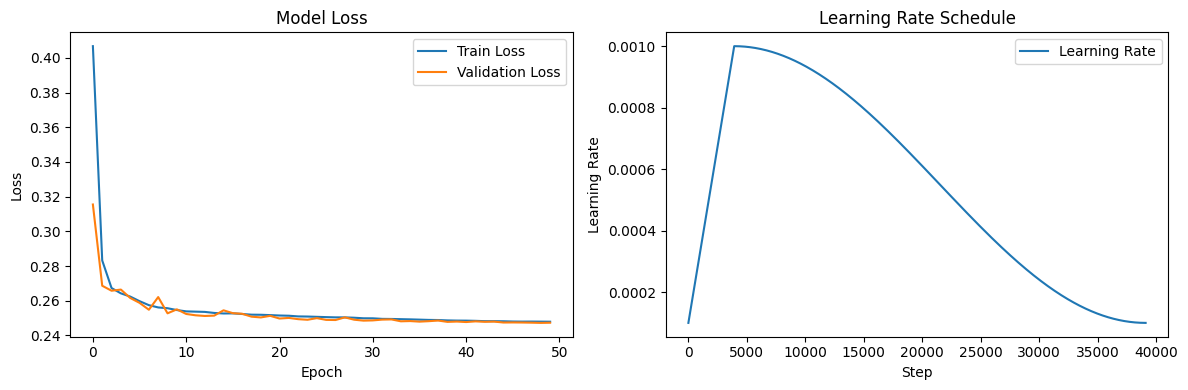

In [12]:
# Plotting cell
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lr_rates, label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Load the trained model
model = tf.keras.models.load_model('best_model.h5', custom_objects={'CosineDecayWithWarmup': CosineDecayWithWarmup})

# Load the normalization parameters
norm_params = np.load('normalization_params.npz')
input_mean, input_std = norm_params['input_mean'], norm_params['input_std']
output_mean, output_std = norm_params['output_mean'], norm_params['output_std']

# Load the test dataset (assuming you've split your data into train and test)
# If not, you can use a portion of your original dataset for testing
inputs, outputs = load_dataset()  # Your function to load the dataset
test_size = int(0.2 * len(inputs))  # Using 20% of data for testing
test_inputs, test_outputs = inputs[-test_size:], outputs[-test_size:]

# Normalize the test inputs
test_inputs_normalized = (test_inputs - input_mean) / (input_std + 1e-8)

# Make predictions
predictions_normalized = model.predict(test_inputs_normalized)

# Denormalize the predictions
predictions = predictions_normalized * (output_std + 1e-8) + output_mean

# Calculate Mean Absolute Error for each coordinate
mae_x = mean_absolute_error(test_outputs[:, 0], predictions[:, 0])
mae_y = mean_absolute_error(test_outputs[:, 1], predictions[:, 1])
mae_z = mean_absolute_error(test_outputs[:, 2], predictions[:, 2])

print(f"Mean Absolute Error:")
print(f"X: {mae_x:.4f}")
print(f"Y: {mae_y:.4f}")
print(f"Z: {mae_z:.4f}")

# Visualize the differences
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, coord in enumerate(['X', 'Y', 'Z']):
    axes[i].scatter(test_outputs[:, i], predictions[:, i], alpha=0.1)
    axes[i].plot([test_outputs[:, i].min(), test_outputs[:, i].max()], 
                 [test_outputs[:, i].min(), test_outputs[:, i].max()], 
                 'r--', lw=2)
    axes[i].set_xlabel(f'Actual {coord}')
    axes[i].set_ylabel(f'Predicted {coord}')
    axes[i].set_title(f'{coord} Coordinate: Actual vs Predicted')

plt.tight_layout()
plt.show()

# Visualize error distribution
error = predictions - test_outputs

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, coord in enumerate(['X', 'Y', 'Z']):
    axes[i].hist(error[:, i], bins=50, edgecolor='black')
    axes[i].set_xlabel(f'Error in {coord}')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Error Distribution for {coord} Coordinate')

plt.tight_layout()
plt.show()

# 3D scatter plot of actual vs predicted points
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(test_outputs[:, 0], test_outputs[:, 1], test_outputs[:, 2], c='blue', label='Actual', alpha=0.1)
ax.scatter(predictions[:, 0], predictions[:, 1], predictions[:, 2], c='red', label='Predicted', alpha=0.1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
ax.set_title('Actual vs Predicted 3D Positions')

plt.show()

In [15]:
def evaluate_inverse_kinematics(model, test_inputs, test_outputs, input_mean, input_std, output_mean, output_std, l1=1.0, l2=1.5, l3=0.5):
    # Normalize test inputs
    test_inputs_norm = (test_inputs - input_mean) / (input_std + 1e-8)
    
    # Get predictions and denormalize
    predictions_norm = model.predict(test_inputs_norm)
    predictions = predictions_norm * (output_std + 1e-8) + output_mean
    
    # Calculate angular error
    angular_error = np.abs(test_outputs - predictions)
    mean_angular_error = np.mean(angular_error, axis=0)
    
    # Calculate end-effector position using forward kinematics on predicted angles
    predicted_positions = np.array([forward_kinematics_3dof(t1, t2, t3, l1, l2, l3) for t1, t2, t3 in predictions])
    
    # Calculate position error
    position_error = np.abs(test_inputs - predicted_positions)
    mean_position_error = np.mean(position_error, axis=0)
    
    print("Mean Angular Error (radians):")
    print(f"Theta1: {mean_angular_error[0]:.4f}")
    print(f"Theta2: {mean_angular_error[1]:.4f}")
    print(f"Theta3: {mean_angular_error[2]:.4f}")
    
    print("\nMean Position Error (meters):")
    print(f"X: {mean_position_error[0]:.4f}")
    print(f"Y: {mean_position_error[1]:.4f}")
    print(f"Z: {mean_position_error[2]:.4f}")
    
    # Calculate relative position error
    relative_error = position_error / (np.abs(test_inputs) + 1e-8)
    mean_relative_error = np.mean(relative_error, axis=0)
    
    print("\nMean Relative Position Error (%):")
    print(f"X: {mean_relative_error[0]*100:.2f}%")
    print(f"Y: {mean_relative_error[1]*100:.2f}%")
    print(f"Z: {mean_relative_error[2]*100:.2f}%")
    
    # Visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    for i, angle in enumerate(['Theta1', 'Theta2', 'Theta3']):
        axes[0, i].scatter(test_outputs[:, i], predictions[:, i], alpha=0.1)
        axes[0, i].plot([-np.pi/2, np.pi/2], [-np.pi/2, np.pi/2], 'r--')
        axes[0, i].set_xlabel(f'Actual {angle} (radians)')
        axes[0, i].set_ylabel(f'Predicted {angle} (radians)')
        axes[0, i].set_title(f'{angle}: Actual vs Predicted')
    
    for i, coord in enumerate(['X', 'Y', 'Z']):
        axes[1, i].scatter(test_inputs[:, i], predicted_positions[:, i], alpha=0.1)
        axes[1, i].plot([test_inputs[:, i].min(), test_inputs[:, i].max()], 
                        [test_inputs[:, i].min(), test_inputs[:, i].max()], 'r--')
        axes[1, i].set_xlabel(f'Original {coord} (meters)')
        axes[1, i].set_ylabel(f'FK of Predicted {coord} (meters)')
        axes[1, i].set_title(f'{coord}: Original vs FK of Predicted')
    
    plt.tight_layout()
    plt.show()
    
    # Histogram of position errors
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for i, coord in enumerate(['X', 'Y', 'Z']):
        axes[i].hist(position_error[:, i], bins=50, edgecolor='black')
        axes[i].set_xlabel(f'{coord} Error (meters)')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'Distribution of {coord} Error')
    plt.tight_layout()
    plt.show()

6250/6250 [==============================] - 16s 3ms/step
Mean Angular Error (radians):
Theta1: 0.0088
Theta2: 0.2859
Theta3: 0.4694

Mean Position Error (meters):
X: 0.0431
Y: 0.0429
Z: 0.1155

Mean Relative Position Error (%):
X: 575.67%
Y: 24.55%
Z: 8.92%


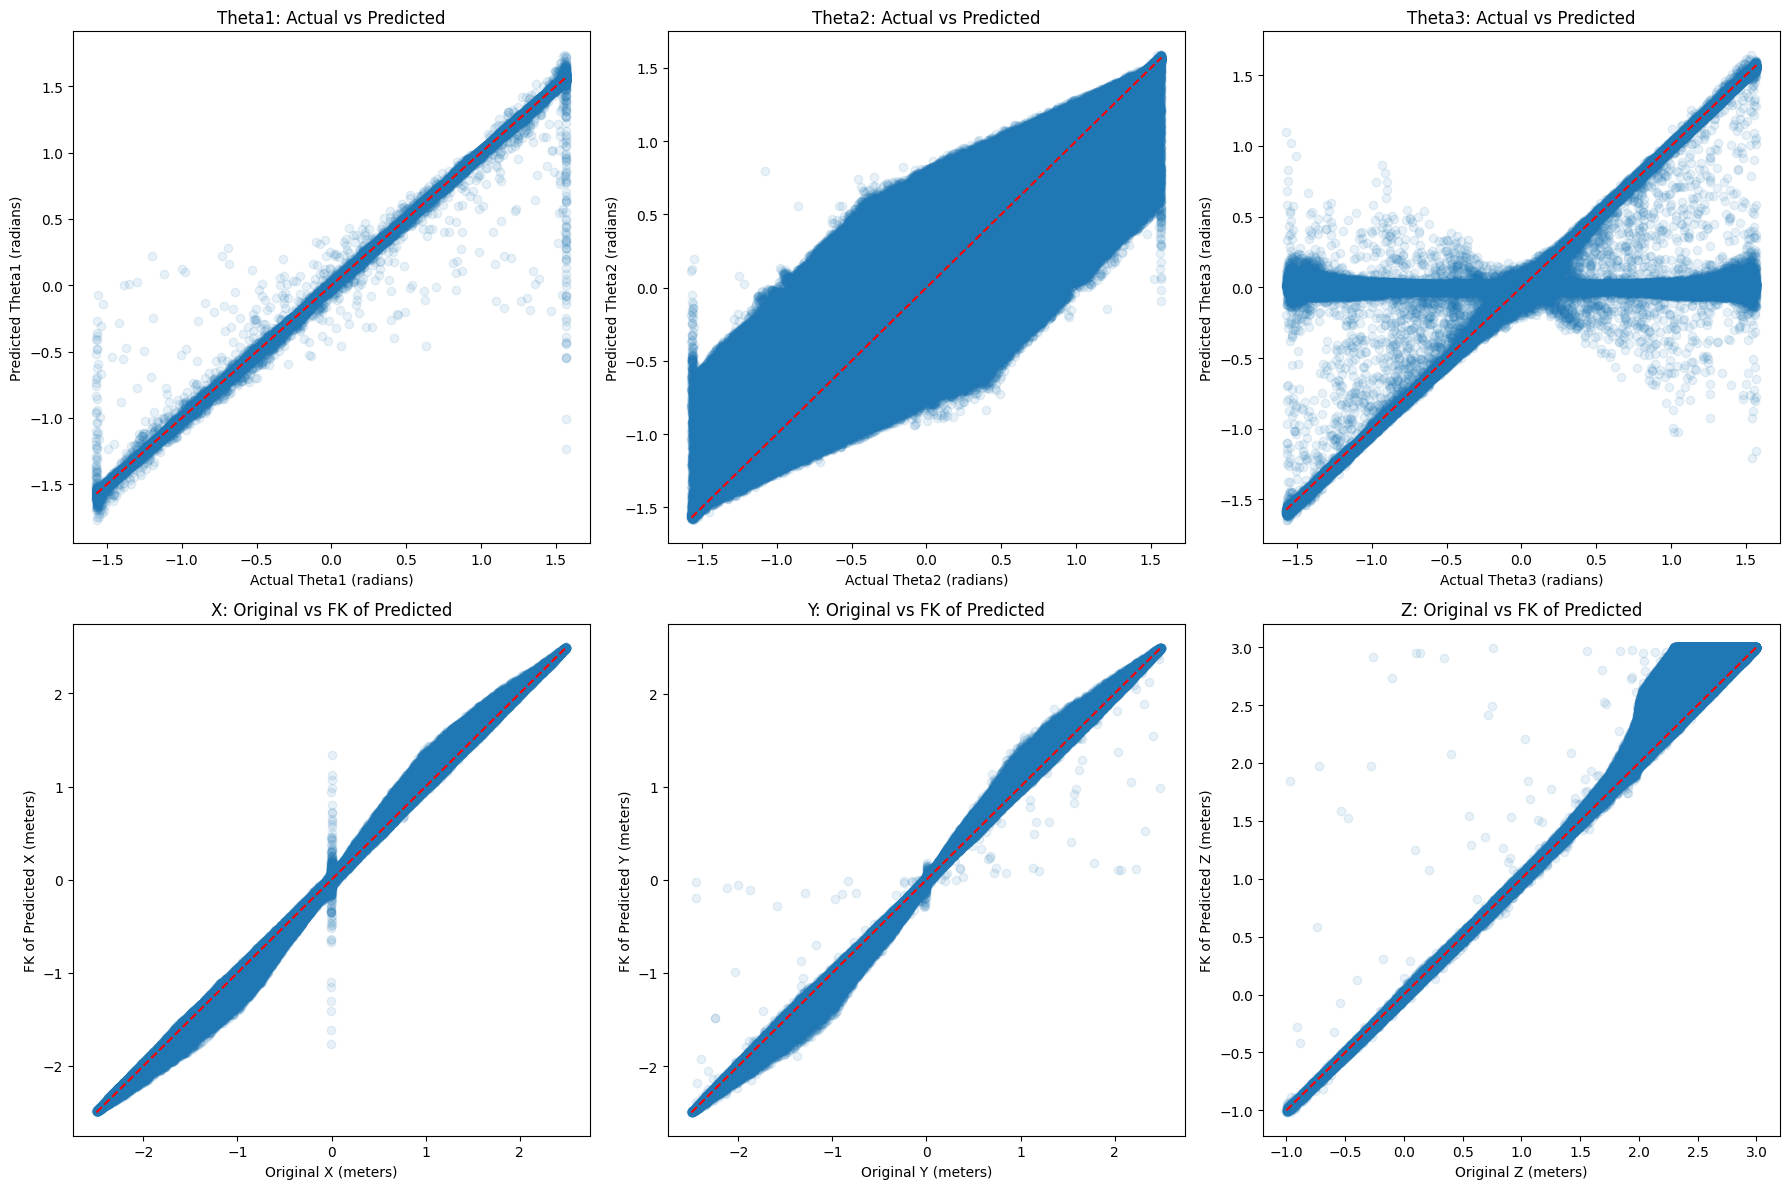

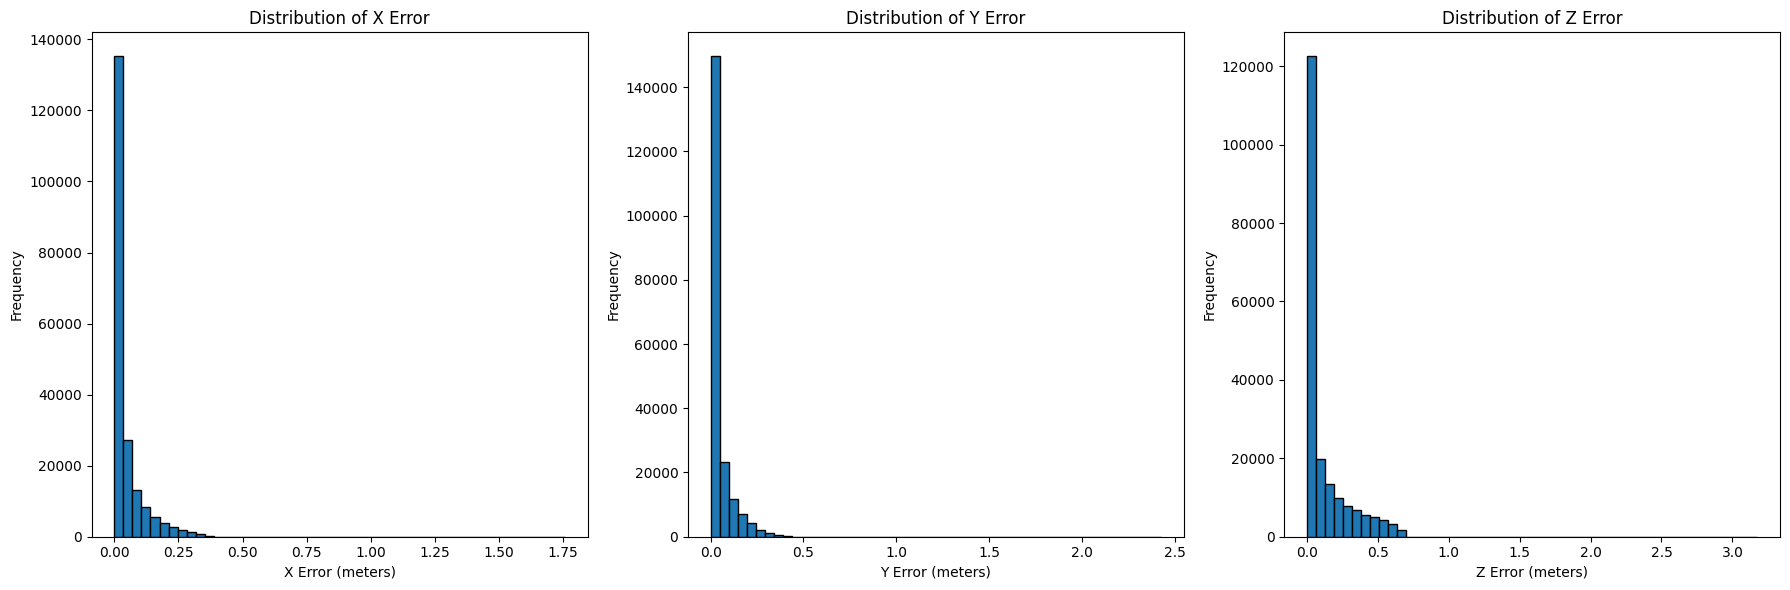

In [17]:
# Evaluate the model
# test_inputs, test_outputs = val_inputs, val_outputs  # Using validation set for testing
# evaluate_inverse_kinematics(trained_model, (test_inputs - input_mean) / (input_std + 1e-8), test_outputs)

evaluate_inverse_kinematics(model, test_inputs, test_outputs, input_mean, input_std, output_mean, output_std)